In [134]:
import json
import requests
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely import Polygon, to_geojson
import pylab as plt

In [135]:
# Containers in FIWARE data platform
fiware_containers = []
with open("./data/WasteContainers_FIWARE.json") as f:
    fiware_containers = json.load(f)

# Containers out of FIWARE data platform
df_no_fiware_containers = pd.read_csv("./data/contenedores_aceite_sin_fiware.csv")

# Valencia districts
districts = gpd.read_file('./data/districtes-distritos.geojson')

In [136]:
containers = []

# Clean containers in FIWARE platform
for container in fiware_containers:
    # Filter oil containers
    if "aceiteContenedoresDipu2023" in container["id"]:

        # Check location
        if (container["location"] is not None) and (
            container["location"]["value"] is not None
        ):

            # Check filling level
            filling_level = "-"
            if "fillingLevel" in container:
                filling_level = container["fillingLevel"]["value"]

                clean_container = {
                    "covered_cells": []
                }
                clean_container["location"] = [
                    container["location"]["value"]["coordinates"]
                ]
                clean_container["id"] = container["id"]

                containers.append(clean_container)

# Containers out of FIWARE platform
for index, row in df_no_fiware_containers.iterrows():
    clean_container = {
        "covered_cells": []
    }
    clean_container["location"] = [[row["geo_point_2d.lon"], row["geo_point_2d.lat"]]]
    clean_container["id"] = row["objectid"]
    containers.append(clean_container)

In [137]:
# Get isochrones
isochrone_range = [5 * 60]

headers = {
    "Accept": "application/json, application/geo+json, application/gpx+xml, img/png; charset=utf-8",
    "Authorization": "5b3ce3597851110001cf62487c1cebfad2324c61823ac5e4fe9be9b1",  # Private
    "Content-Type": "application/json; charset=utf-8",
}

for container in containers:
    body = {"locations": container["location"], "range": isochrone_range}
    call = requests.post(
        " http://localhost:8080/ors/v2/isochrones/foot-walking",
        json=body,
        headers=headers,
    )
    result = call.json()
    container["isochrone"] = Polygon(
        result["features"][0]["geometry"]["coordinates"][0]
    )

gdf_containers = gpd.GeoDataFrame(containers)

In [138]:
# Create grid
# Source: https://dmnfarrell.github.io/plotting/geopandas-grids
def create_grid(gdf=None, bounds=None, n_cells=10, overlap=False, crs="EPSG:29902"):
    """Create square grid that covers a geodataframe area
    or a fixed boundary with x-y coords
    returns: a GeoDataFrame of grid polygons
    see https://james-brennan.github.io/posts/fast_gridding_geopandas/
    """

    import geopandas as gpd
    import shapely

    if bounds != None:
        xmin, ymin, xmax, ymax = bounds
    else:
        xmin, ymin, xmax, ymax = gdf.total_bounds

    # get cell size
    cell_size = (xmax - xmin) / n_cells
    # create the cells in a loop
    grid_cells = []
    for x0 in np.arange(xmin, xmax + cell_size, cell_size):
        for y0 in np.arange(ymin, ymax + cell_size, cell_size):
            x1 = x0 - cell_size
            y1 = y0 + cell_size
            poly = shapely.geometry.box(x0, y0, x1, y1)
            # print (gdf.overlay(poly, how='intersection'))
            grid_cells.append(poly)

    cells = gpd.GeoDataFrame(grid_cells, columns=["geometry"], crs=crs)
    if overlap == True:
        cols = ["grid_id", "geometry", "grid_area"]
        cells = cells.sjoin(gdf, how="inner").drop_duplicates("geometry")
    return cells

# Transform to proxy crs
districts = districts.to_crs("EPSG:29902")

# Create grid
grid = create_grid(districts, n_cells=50, overlap=True, crs="EPSG:29902")

# Transform to original crs
grid = grid.to_crs("EPSG:4326")

# Add incremental ID to cells
grid.insert(0, 'id', range(0, len(grid)))


In [139]:
import json
import rasterio
from rasterio.mask import mask

spanishPopRaster = rasterio.open("./data/spain_pop.tif")


def get_population(poly):
    # Convert string to JSON
    geoJSON = json.loads(poly)

    # Load population raster, mask it by the polygon and crop it
    try:
        out_image, out_transform = mask(spanishPopRaster, [geoJSON], crop=True)

        # Clean negative values
        out_image = out_image[out_image >= 0]

        # Get total population
        totalPop = int(out_image.sum())

        return totalPop
    except ValueError as error:
        return {"error": error}


# Get population for each cell
grid_dict = grid.to_dict("records")

for cell in grid_dict:
    # Convert shapely.Polygon to geojson
    polygon = to_geojson(cell["geometry"])

    # Get pop in the cell
    population = get_population(polygon)
    
    # Store it
    cell["population"] = population



<Axes: >

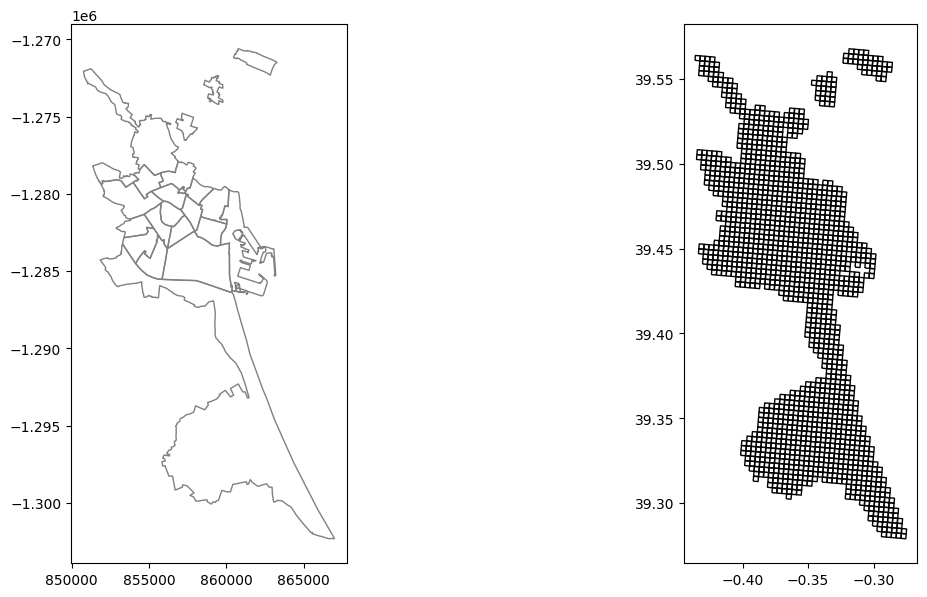

In [140]:
fig,ax = plt.subplots(1,2,figsize=(14,7))
axs=ax.flat
districts.plot(ec='gray',fc="none",figsize=(10,10),ax=axs[0])
grid.plot(fc="none", ec='black',ax=axs[1])

In [142]:
# Determine which centroids are covered by the isochrone
for cell in grid_dict:
    for container in containers:
        if container["isochrone"].contains(cell["geometry"].centroid):
            cell["covered"] = True
            cell["color"] = "green"
            container["covered_cells"].append(cell["id"])

grid = gpd.GeoDataFrame(grid_dict)

# Replance NaN
grid['color'] = grid['color'].fillna("white")
grid['covered'] = grid['covered'].fillna(False)

grid_dict = grid.to_dict("records")


<Axes: >

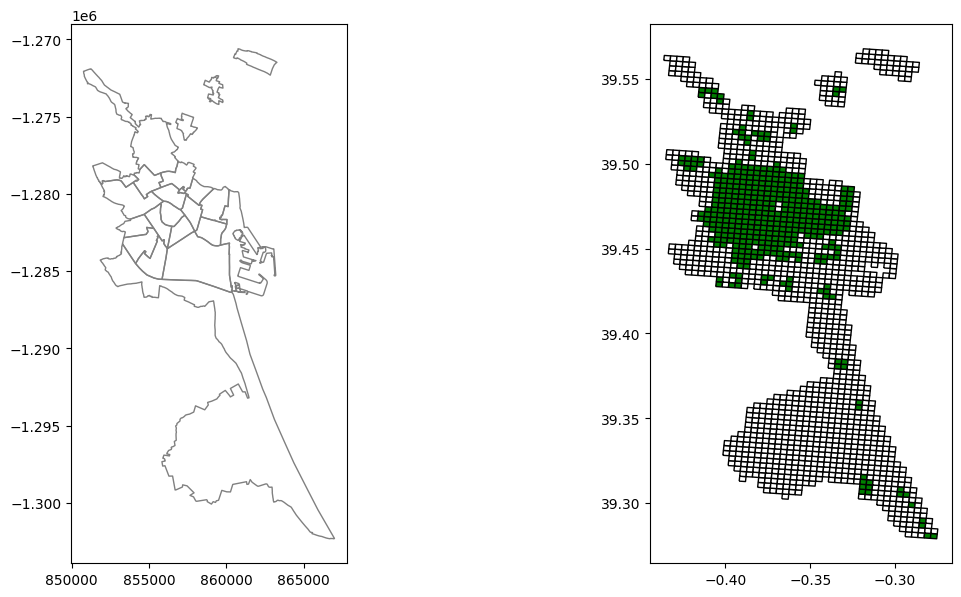

In [143]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
axs = ax.flat
districts.plot(ec='gray',fc="none",figsize=(10,10),ax=axs[0])
grid.plot(color=grid.color, ec="black", ax=axs[1])

In [146]:
# Create solver
from ortools.linear_solver import pywraplp
solver = pywraplp.Solver.CreateSolver("GLOP")

In [150]:
# Decision variables
variables = {
    "Xi": [],
    "Yj": []
}

# Xi: 1 if a container is placed at location i, 0 otherwise
for container in containers:
    v = solver.IntVar(0,1,str(container['id']))
    variables["Xi"].append(v)

# Yj: 1 if cell j is covered, 0 otherwise
for cell in grid_dict:
    v = solver.IntVar(0,1,str(cell['id']))
    variables["Yj"].append(v)

In [151]:
# Objective function
objective = solver.Objective()
objective.SetMaximization()

for i in range(len(variables["Yj"])):
  v = variables["Yj"][i]
  population = grid_dict[i]["population"]
  objective.SetCoefficient(v, population)